In [1]:
import scipy
from scipy import optimize
import numpy as np
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from time import time
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
df = pd.read_pickle('s&p_5Y_hist.pkl')
symbols = sorted([el[0] for el in list(df.columns)[::7]])

In [176]:
eg_df_crisis = df[[(ticker, 'Close') for ticker in symbols]].iloc[725:725+51]
# eg_df_crisis = df[[(ticker, 'Close') for ticker in symbols]].tail(51)
eg_df_crisis = eg_df_crisis.interpolate()
lr_eg_df_crisis = np.log(eg_df_crisis.values[1:]) - np.log(eg_df_crisis.values[:-1])
lr_eg_df_crisis[np.isnan(lr_eg_df_crisis)] = 0

In [177]:
lr_eg_df_crisis -= lr_eg_df_crisis.mean(0)
dm_crisis = pdist(lr_eg_df_crisis.T, lambda u, v: (u*v).sum()/(u.std()*v.std()))
dm_crisis[pd.isna(dm_crisis)] = 0
dm_crisis = squareform(dm_crisis)

<ipython-input-177-729a3ebfab06>:2: RuntimeWarning: invalid value encountered in double_scalars
  dm_crisis = pdist(lr_eg_df_crisis.T, lambda u, v: (u*v).sum()/(u.std()*v.std()))


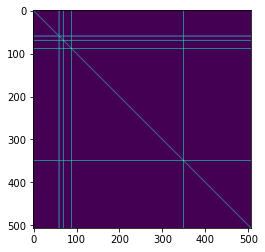

In [178]:
plt.imshow(dm_crisis==0)

(array([1.4478e+04, 9.2610e+03, 8.2190e+03, 7.8880e+03, 8.1520e+03,
        8.3710e+03, 8.7400e+03, 9.2860e+03, 1.0040e+04, 1.0440e+04,
        1.1281e+04, 1.1445e+04, 1.2403e+04, 1.2896e+04, 1.3728e+04,
        1.4179e+04, 1.4789e+04, 1.5153e+04, 1.5797e+04, 1.6591e+04,
        1.6825e+04, 1.7405e+04, 1.7930e+04, 1.8553e+04, 1.8954e+04,
        1.9573e+04, 1.9611e+04, 1.9894e+04, 2.0372e+04, 2.0750e+04,
        2.0860e+04, 2.0756e+04, 2.0943e+04, 2.1188e+04, 2.1061e+04,
        2.1177e+04, 2.1154e+04, 2.0941e+04, 2.0469e+04, 2.0189e+04,
        2.0390e+04, 1.9642e+04, 1.9341e+04, 1.8746e+04, 1.8481e+04,
        1.7867e+04, 1.7261e+04, 1.6877e+04, 1.6376e+04, 1.5445e+04,
        1.4861e+04, 1.4462e+04, 1.3692e+04, 1.2983e+04, 1.2137e+04,
        1.1642e+04, 1.0657e+04, 1.0078e+04, 9.5350e+03, 8.7980e+03,
        7.9680e+03, 7.2550e+03, 6.6530e+03, 6.1490e+03, 5.5260e+03,
        4.9270e+03, 4.3090e+03, 3.7930e+03, 3.4280e+03, 3.0940e+03,
        2.5910e+03, 2.2300e+03, 1.9660e+03, 1.68

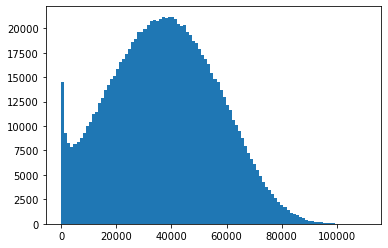

In [179]:
M = 2000000
i_s, j_s, k_s = np.random.choice(np.arange(dm_crisis.shape[0]), size=3*M).reshape(3, M)
J_crisis = np.abs(dm_crisis[i_s, j_s] * dm_crisis[j_s, k_s] * dm_crisis[k_s,i_s])
J_crisis = J_crisis[J_crisis!=0]
J_crisis = np.random.choice(J_crisis, replace=False, size=1000000)
plt.hist(J_crisis, bins=100)

In [194]:
def q(Q, B, J):
    a = np.exp(2*B*Q)
    b = 2*np.exp(-2*B*J*np.tanh(B*Q))
    c = np.exp(-2*B*Q)
    return (a - b + c)/(a + b + c)

def Q(y, T):
    global hist, bin_edges
    B = 1/T
    Q_ = (((bin_edges[:-1] + bin_edges[1:])/2) * hist * q(y, B, ((bin_edges[:-1] + bin_edges[1:])/2)) * (bin_edges[1] - bin_edges[0])).sum() / N
    return Q_

def P(T, y):
    x = float(optimize.fixed_point(Q, y, args=(T,)))**2 + 1e-8
    return 1/(1e10*(x**2)) + x**2

def P_mv(x):
    T, y = x
    x = float(optimize.fixed_point(Q, y, args=(T,), maxiter=1000))**2 + 1e-8
    print(T,y,x,1/(1e10*(x**2)) + x**2)
    return 1/(1e10*(x**2)) + x**2

In [201]:
start = time()

hist, bin_edges = np.histogram(J_crisis, bins=100)
hist = hist/hist.sum()
T = 30
N = 10000000
sp = .01
while Q(sp, T) > sp:
    sp += .01
fp = float(optimize.fixed_point(Q, sp, args=(T,)))
res = scipy.optimize.minimize(P_mv, np.array([T, fp]), options={'maxiter':1000})

end = time()
print('Processing time: {0}s'.format(round(end-start, 2)))

res

30.0 4.131058349668829 17.065643098368554 291.2361743608946
30.00000001490116 4.131058349668829 17.065643098368106 291.2361743608793
30.0 4.1310583645699905 17.065643098368554 291.2361743608946
30.001026153564453 4.131058349668829 17.065643067342588 291.2361733019385
30.001026168465614 4.131058349668829 17.065643067342148 291.23617330192343
30.001026153564453 4.1310583645699905 17.065643067342588 291.2361733019385
30.005130767822266 4.131058349668829 17.065642943164455 291.2361690635791
30.005130782723427 4.131058349668829 17.065642943164 291.2361690635636
30.005130767822266 4.1310583645699905 17.065642943164455 291.2361690635791
30.021549224853516 4.131058349668829 17.065642445262277 291.23615206953775
30.021549239754677 4.131058349668829 17.065642445261823 291.23615206952223
30.021549224853516 4.1310583645699905 17.065642445262277 291.23615206953775
30.087223052978516 4.131058349668829 17.065640434565022 291.236083441861
30.087223067879677 4.131058349668829 17.06564043456456 291.2360

      fun: 2.0000064520828514e-05
 hess_inv: array([[  5.94663263, -15.3445555 ],
       [-15.3445555 ,  39.61995602]])
      jac: array([5.53751329e-06, 1.39669964e-07])
  message: 'Optimization terminated successfully.'
     nfev: 180
      nit: 6
     njev: 60
   status: 0
  success: True
        x: array([441.07886459,   4.13027979])